In [2]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt


from os.path import join
from IPython import display
from sklearn.datasets import load_digits

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, rand_score, adjusted_rand_score,  mutual_info_score, adjusted_mutual_info_score, homogeneity_completeness_v_measure, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [3]:
# Extra
from sklearn.neighbors import DistanceMetric, KNeighborsClassifier
from scipy.cluster.hierarchy import linkage
from sklearn.cluster import AgglomerativeClustering, DBSCAN, Birch, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.model_selection import GridSearchCV

In [4]:
DATA_PATH = "data/"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Подбираем лучшую иерархическую кластеризацию

5 баллов

Перед тем, как начинать работу с реальными данными, я предлагаю потренироваться работать с кластеризацией и поизучать различные гиперпараметры. На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Часть моментов мы не разбирали на лекции, поэтому вам нужно самим разобрать в них перед тем, как начинать делать данное задание.

Загрузим наши данные:

In [5]:
data = load_digits()
X, y = data.data, data.target

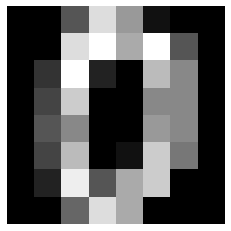

In [6]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

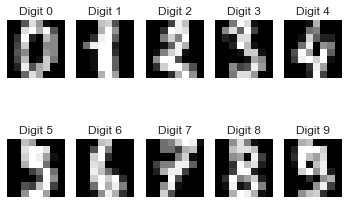

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)

for i, dig in enumerate(np.unique(y)):
    axs.flatten()[i].imshow(X[list(np.where(y==dig))][0].reshape(8, 8).astype(int), cmap='gray')
    axs.flatten()[i].set_title("Digit " + str(dig))
    axs.flatten()[i].axis("off")

Работать будем с изображениями рукописных цифр. Каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`). Укажите для каждого алгоритма число кластеров равное количеству классов в `y`.

Перед тем, как начинать работу с реальными данными, я предлагаю потренироваться работать с кластеризацией и поизучать различные гиперпараметры. На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

In [8]:
def algorithm_selection(X, distances=['l2'], algorithms=['complete'], metrics=['Homogeneity', 'Completeness', 'V-measure']):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния ('euclidean', 'manhattan', 'l1', 'l2', 'cosine', 'chebyshev', 'minkowski', 'canberra')
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')
    :return compare_dataframe: таблица с метриками кластеризации
    """
    X, y = data.data, data.target
    n_clusters = len(np.unique(y))

    compare_dic = {"distance_1": [], "linkage_1": [], "homogenity_1": [], "completeness_1": [], "v_measure_1": [], "silhouette_1": []}
    
    param_distances = ['euclidean', 'manhattan', 'l1', 'l2', 'cosine', 'chebyshev', 'minkowski', 'canberra']
    param_algorithm = ['average', 'single', 'complete']
    param_metrics = ['Homogeneity', 'Completeness', 'V-measure', 'Silhouette']
    i = 1
    for dist in distances:
        for link in algorithms:
            y_pred = AgglomerativeClustering(n_clusters=n_clusters, affinity=dist, linkage=link).fit_predict(X)
            compare_dic[f'distance_{i}'] = [dist]
            compare_dic[f'linkage_{i}'] = [link]
            
            homogenity, completeness, v_measure = homogeneity_completeness_v_measure(y, y_pred, beta=0.5)
            silhouette = silhouette_score(X, y_pred)
            compare_dic[f"homogenity_{i}"] = [homogenity]
            compare_dic[f"completeness_{i}"] = [completeness]
            compare_dic[f"v_measure_{i}"] = [v_measure]
            compare_dic[f'silhouette_{i}'] = [silhouette]
            i += 1

    compare_dataframe = pd.DataFrame(compare_dic)
    compare_dataframe = compare_dataframe.transpose()

    return compare_dataframe

algorithm_selection(data)

,0
distance_1,l2
linkage_1,complete
homogenity_1,0.590549
completeness_1,0.637772
v_measure_1,0.605494
silhouette_1,0.119271


### Задание 2. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 2.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [9]:
fc_data = pd.read_csv(join(DATA_PATH, "flow_c_data.csv"), index_col=0)

In [10]:
fc_data

,FSC-A,SSC-A,HLA-DR,CD3,CD45,CD14,CD56,CD19,CD11c
0,0.722199,0.154232,0.494449,0.512853,4.057328,1.019255,4.007273,-1.406912,0.384406
1,0.751073,0.114618,4.671924,0.822042,4.933149,0.159388,-0.216407,6.034845,0.577039
2,1.108188,0.150011,-0.422857,4.006353,5.616384,0.519223,0.783077,-0.318668,-0.493832
3,0.553310,0.119929,0.345968,3.332310,5.260935,1.481229,0.264846,0.694883,3.416960
4,0.774884,0.076984,4.984963,0.885501,4.562367,0.217117,0.086279,5.563345,0.471591
...,...,...,...,...,...,...,...,...,...
9995,1.180762,0.441445,2.437344,1.526085,4.455114,4.880495,0.347480,-0.591343,2.857737
9996,0.768279,0.111863,0.812236,4.254496,5.008437,1.303261,-0.130244,0.344169,-0.626795
9997,1.314964,0.233584,4.144130,1.311947,5.340263,1.598675,-0.287353,-0.887078,4.369294
9998,0.894135,0.137300,-0.226186,0.246804,4.430212,0.457881,2.404284,-0.112999,0.069239


##### YOUR TURN TO CODE:

In [11]:
fc_data.describe()

,FSC-A,SSC-A,HLA-DR,CD3,CD45,CD14,CD56,CD19,CD11c
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.962458,0.165415,1.791579,3.280391,5.169845,1.097182,0.412223,1.219683,0.569898
std,0.500012,0.190773,2.027281,2.112079,0.518247,1.375876,1.176967,2.285305,1.502445
min,0.144786,0.021657,-7.634172,-2.517639,-8.329666,-8.833883,-12.358701,-9.640775,-11.085437
25%,0.798804,0.105550,0.275056,1.401943,4.922227,0.389746,-0.195978,-0.146948,-0.498781
50%,0.908574,0.130543,1.194313,4.373660,5.234119,0.672853,0.053267,0.244121,0.272297
75%,1.052034,0.162536,3.696976,4.842212,5.481218,1.065076,0.378576,0.908374,1.220576
max,42.954485,15.460997,12.946668,13.844391,13.710922,6.294236,6.461899,7.208721,6.840864


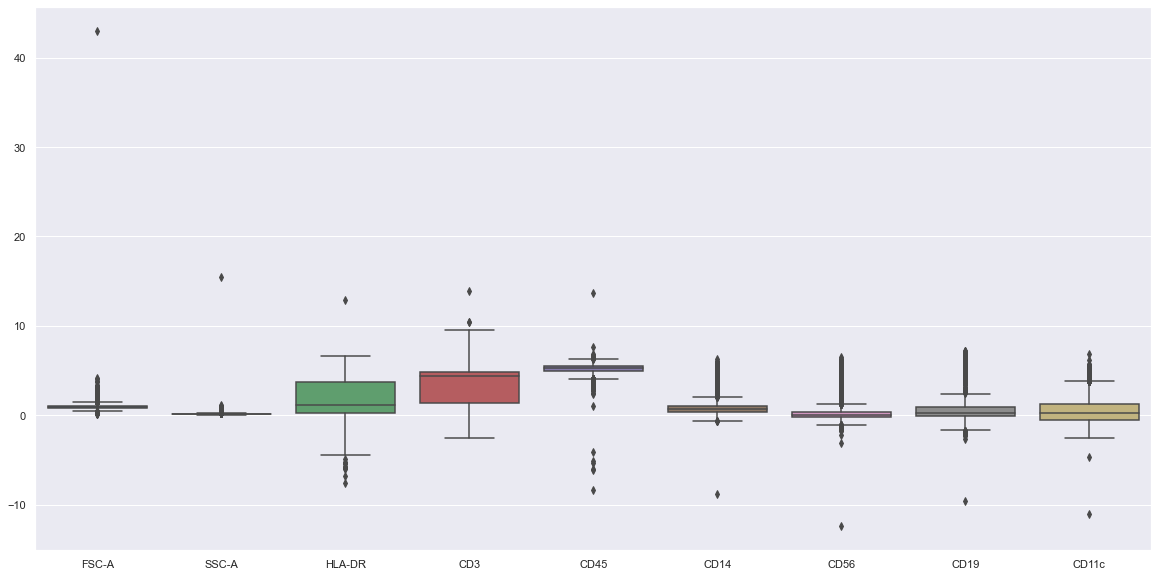

In [12]:
sns.set(rc={"figure.figsize":(20,10)})
sns.boxplot(data=fc_data);
plt.rcParams["figure.figsize"] = 12, 9

#### 2.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE (при желании можно также воспользоваться UMAP, но для него необходимо устанавливать дополнительную [библиотеку](https://umap-learn.readthedocs.io/en/latest/)). 

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [13]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: число соседей
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)

    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity, random_state=SEED)
    tsne_embedding = tnse.fit_transform(pca_embedding)

    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

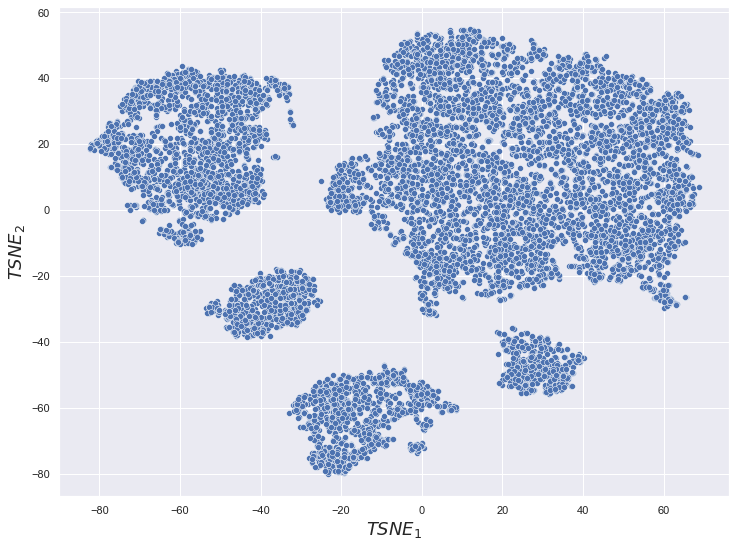

In [14]:
tsne_embedding_2D = plot_tsne(fc_data)

In [15]:
def plot_tsne_3D(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: число соседей
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)

    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=3, init=pca_embedding[:, :3], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity, random_state=SEED)
    tsne_embedding = tnse.fit_transform(pca_embedding)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')

    ax.set_xlabel("$TSNE_1$", fontsize=18)
    ax.set_ylabel("$TSNE_2$", fontsize=18)
    ax.set_zlabel("$TSNE_3$", fontsize=18)
    
    ax.scatter(tsne_embedding[:, 0], 
               tsne_embedding[:, 1], 
               tsne_embedding[:, 2],
               c=color, cmap="Pastel1")

    plt.show()
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

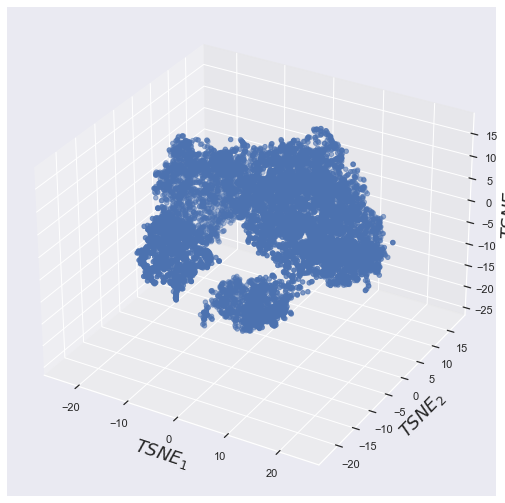

In [16]:
# %matplotlib notebook - to activate interactive 3D
tsne_embedding_3D = plot_tsne_3D(fc_data)

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

In [17]:
gaussian_model = GaussianMixture(n_components=4).fit(fc_data)

gaussian_result = gaussian_model.predict(fc_data)

print(f"Silhouette Score: {silhouette_score(fc_data, gaussian_result)}")
gaussian_result


Silhouette Score: 0.5001047203215502


array([3, 1, 3, ..., 2, 3, 3])

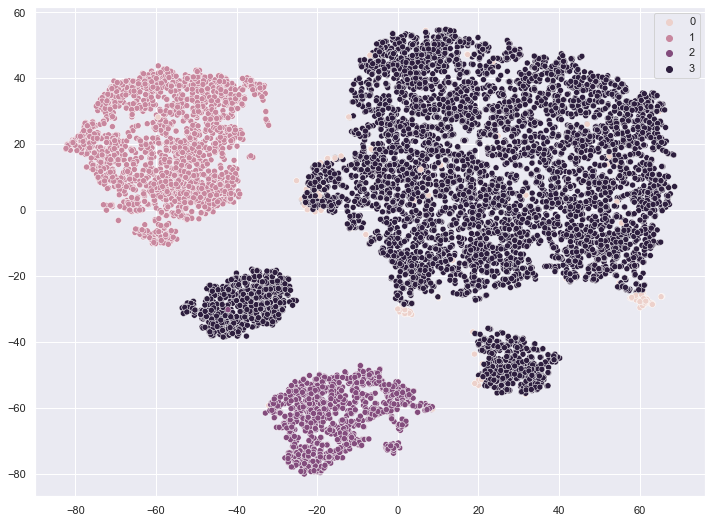

In [17]:
sns.scatterplot(x=tsne_embedding_2D[:, 0],
                y=tsne_embedding_2D[:, 1],
                hue=gaussian_result);

In [18]:
#Не работает
dbscan_model = DBSCAN(eps=0.25, min_samples=10)

dbscan_result = dbscan_model.fit_predict(fc_data)

#print(f"Silhouette Score: {silhouette_score(fc_data, dbscan_result)}") 


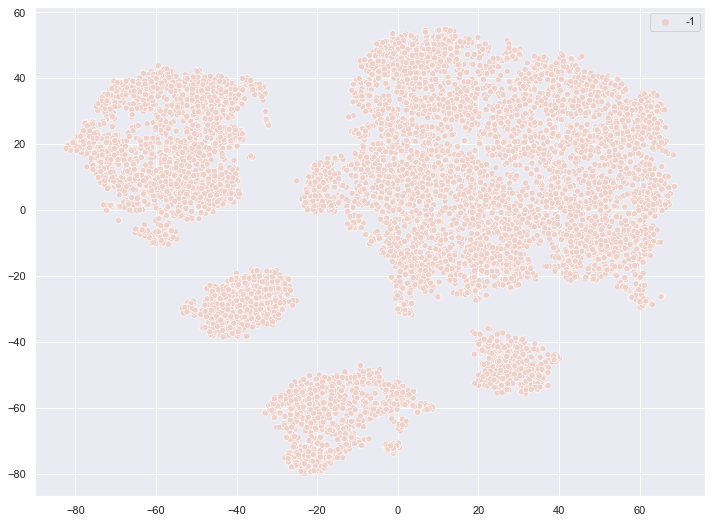

In [19]:
sns.scatterplot(x=tsne_embedding_2D[:, 0],
                y=tsne_embedding_2D[:, 1],
                hue=dbscan_result);

In [20]:
birch_model = Birch(threshold=0.03, n_clusters=4).fit(fc_data)

birch_result = birch_model.predict(fc_data)

print(f"Silhouette Score: {silhouette_score(fc_data, birch_result)}") 

Silhouette Score: 0.6114468221314616


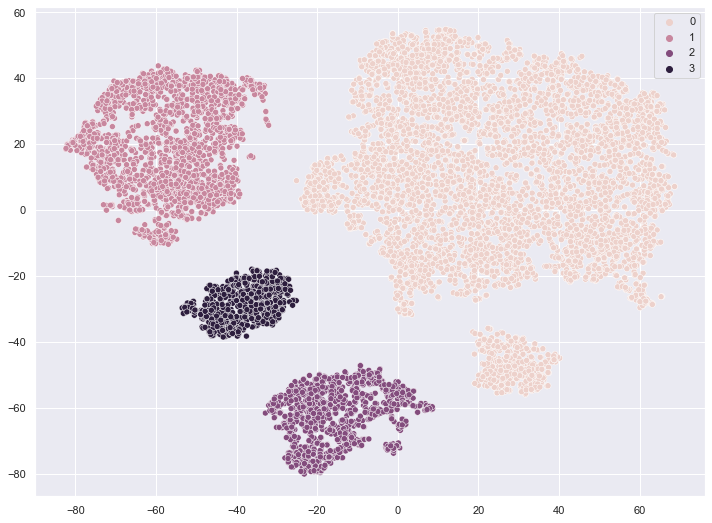

In [21]:
sns.scatterplot(x=tsne_embedding_2D[:, 0],
                y=tsne_embedding_2D[:, 1],
                hue=birch_result);

Например, в случае `KMeans` это можно сделать следующим образом:

## KMeans

In [22]:
kmeans = KMeans(n_clusters=4, random_state=SEED).fit(fc_data)
pred_labels = kmeans.predict(fc_data)

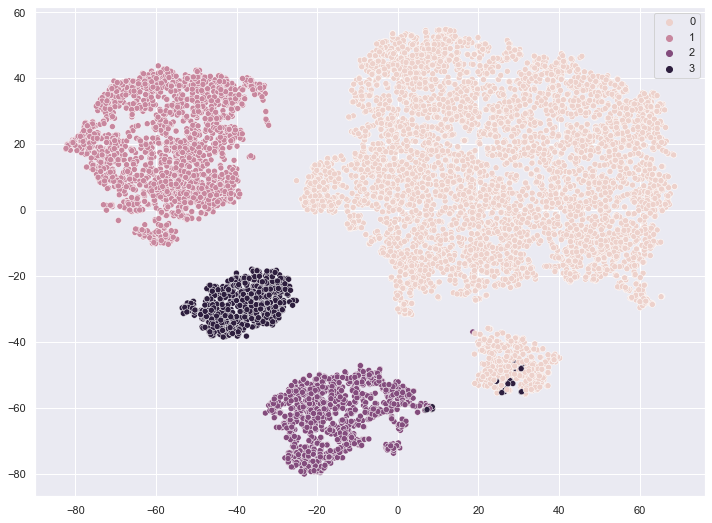

In [23]:
sns.scatterplot(x=tsne_embedding_2D[:, 0],
                y=tsne_embedding_2D[:, 1],
                hue=pred_labels);

In [24]:
print(f"Silhouette Score: {silhouette_score(fc_data, pred_labels)}")

Silhouette Score: 0.6103014000983127


Теперь попробуйте другие методы кластеризации, которые мы прошли (или которые вы хотите сами).

Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

СМ. ВЫШЕ (Birch - лучший)

In [25]:
spect_model = SpectralClustering(n_clusters=4, assign_labels='discretize', random_state=SEED)

In [26]:
spect_result = spect_model.fit_predict(fc_data)

In [27]:
print(f"Silhouette Score: {silhouette_score(fc_data, spect_result)}") 

Silhouette Score: 0.6101665742572265


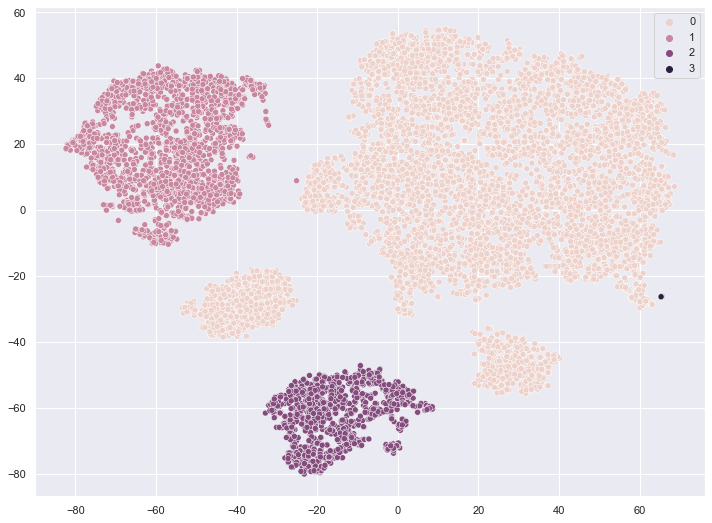

In [28]:
sns.scatterplot(x=tsne_embedding_2D[:, 0],
                y=tsne_embedding_2D[:, 1],
                hue=spect_result);

#### 2.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

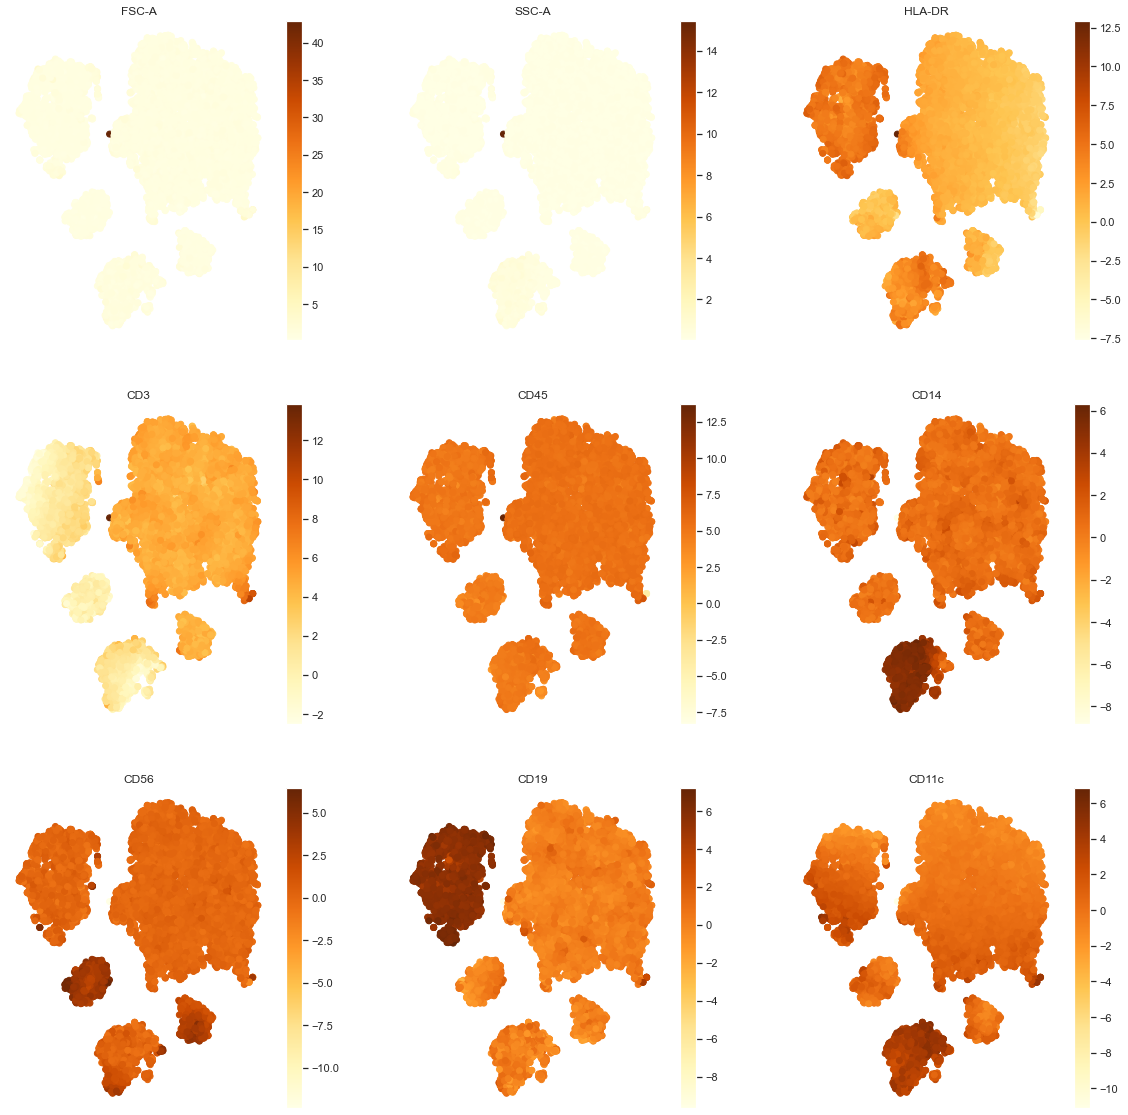

In [29]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data.columns, axes.ravel()):
    scatter = ax.scatter(tsne_embedding_2D[:, 0], tsne_embedding_2D[:, 1], 
                         c=fc_data[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Вам необходимо узнать, какие маркеры характерны для каких типов клеток, и в зависимости от этого проаннотировать кластера.

B_cells: Высокий уровень экспрессии CD19.
T_cells: Высокий уровень экспрессии CD3, но низкий уровень CD19.
Monocytes: Высокий уровень экспрессии CD14 и CD11c.
Other cells: В остальных случаях, когда нет выраженного уровня указанных маркеров.

In [30]:
fc_data.columns

Index(['FSC-A', 'SSC-A', 'HLA-DR', 'CD3', 'CD45', 'CD14', 'CD56', 'CD19',
       'CD11c'],
      dtype='object')

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

In [31]:
cell_type_cluster_map = {0: "T_cells", 
                         1: "B_cells", 
                         2: "Monocytes", 
                         3: "Other_cells"}

In [32]:
labels_of_best_clustering = birch_result

In [33]:
labeled_fc_data = fc_data.assign(Population=labels_of_best_clustering)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

Посчитайте, как распределены типы клеток:

In [34]:
labeled_fc_data["Population"].value_counts()

T_cells        6231
B_cells        2035
Monocytes      1099
Other_cells     635
Name: Population, dtype: int64

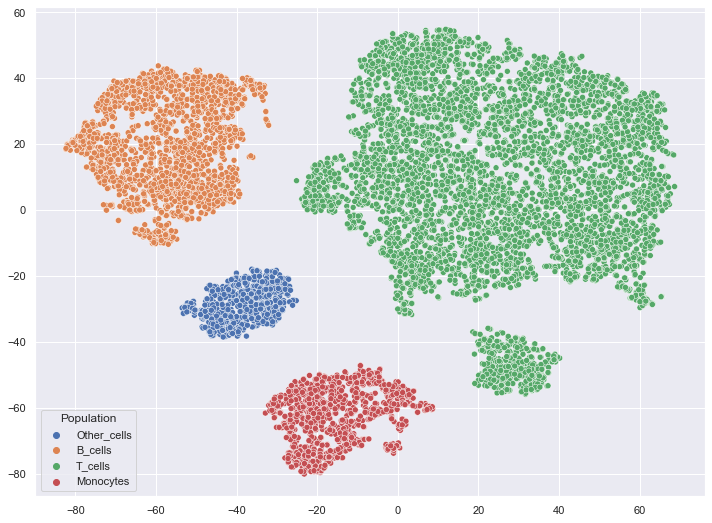

In [35]:
sns.scatterplot(x=tsne_embedding_2D[:, 0],
                y=tsne_embedding_2D[:, 1],
                hue=labeled_fc_data["Population"]);

#### 2.4. Атоматическая аннотация

5 баллов

Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Мы с вами прошли много моделей, поэтому попробуйте как можно больше, а также поразбирайтесь с подбором гиперпараметров.

Подумайте о том, какая стратегия валидации модели здесь подойдет. Не забывайте, что когда вы подбираете гиперпараметры, то лучше это делать на кросс валидации, а также оставлять еще один набор данных в качестве итогового теста.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

In [36]:
X = labeled_fc_data.drop("Population", axis=1)
y = labeled_fc_data.Population
X_train, X_test, y_train, y_test = train_test_split(X, y.values, random_state=SEED)

In [37]:
y_pred1 = GaussianNB().fit(X_train, y_train).predict(X_test)
y_pred2 = tree.DecisionTreeClassifier().fit(X_train, y_train).predict(X_test)
y_pred3 = KNeighborsClassifier(n_neighbors=20).fit(X_train, y_train).predict(X_test)

In [38]:
qual1 = f1_score(y_test, y_pred1, average="macro")
qual2 = f1_score(y_test, y_pred2, average="macro")
qual3 = f1_score(y_test, y_pred3, average="macro")

In [39]:
print(f"GaussianNB f1: {qual1:.03f}")
print(f"DecisionTreeClassifier f1: {qual2:.03f}")
print(f"KNeighborsClassifier f1: {qual3:.03f}")

GaussianNB f1: 0.997
DecisionTreeClassifier f1: 0.998
KNeighborsClassifier f1: 1.000


In [40]:
n_cv = 10

GNB_params = {'var_smoothing': np.logspace(0,-9, num=100)}
DTC_params = {'criterion':['gini','entropy'],'max_depth': list(range(1, 500))}
KNC_params = {'n_neighbors': list(range(1, 100))}

GNB = GaussianNB()
DTC = tree.DecisionTreeClassifier()
KNC = KNeighborsClassifier()

# use any cross validation technique 
GNB_svc = GridSearchCV(GNB,
                        GNB_params,
                        cv=n_cv,  
                        verbose=1,
                        scoring='accuracy').fit(X_train, y_train)
DTC_svc = GridSearchCV(DTC,
                        DTC_params,
                        cv=n_cv,  
                        verbose=1,
                        scoring='accuracy').fit(X_train, y_train)
KNC_svc = GridSearchCV(KNC,
                        KNC_params,
                        cv=n_cv,  
                        verbose=1,
                        scoring='accuracy').fit(X_train, y_train)

GNB_svc.best_params_, DTC_svc.best_params_, KNC_svc.best_params_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 998 candidates, totalling 9980 fits
Fitting 10 folds for each of 99 candidates, totalling 990 fits


({'var_smoothing': 0.1},
 {'criterion': 'gini', 'max_depth': 39},
 {'n_neighbors': 1})

In [41]:
y_pred1 = GaussianNB(var_smoothing=0.1).fit(X_train, y_train).predict(X_test)
y_pred2 = tree.DecisionTreeClassifier(criterion='gini', max_depth=15).fit(X_train, y_train).predict(X_test)
y_pred3 = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train).predict(X_test)

qual1 = f1_score(y_test, y_pred1, average="macro")
qual2 = f1_score(y_test, y_pred2, average="macro")
qual3 = f1_score(y_test, y_pred3, average="macro")

print(f"GaussianNB after tune f1: {qual1:.03f}")
print(f"DecisionTreeClassifier after tune f1: {qual2:.03f}")
print(f"KNeighborsClassifier after tune f1: {qual3:.03f}")

GaussianNB after tune f1: 0.999
DecisionTreeClassifier after tune f1: 0.995
KNeighborsClassifier after tune f1: 1.000


In [42]:
labeled_fc_data.Population.value_counts()

T_cells        6231
B_cells        2035
Monocytes      1099
Other_cells     635
Name: Population, dtype: int64

In [43]:
df_majority = labeled_fc_data[labeled_fc_data['Population'] == 'T_cells']
df_minority_1 = labeled_fc_data[labeled_fc_data['Population'] == 'B_cells']
df_minority_2 = labeled_fc_data[labeled_fc_data['Population'] == 'Monocytes']
df_minority_3 = labeled_fc_data[labeled_fc_data['Population'] == 'Other_cells']


In [44]:
df_majority, df_minority_1, df_minority_2, df_minority_3

(         FSC-A     SSC-A    HLA-DR       CD3      CD45      CD14      CD56  \
 2     1.108188  0.150011 -0.422857  4.006353  5.616384  0.519223  0.783077   
 3     0.553310  0.119929  0.345968  3.332310  5.260935  1.481229  0.264846   
 10    0.706134  0.179659 -0.191261  4.439595  5.551211  0.226791  2.273899   
 12    0.972866  0.100368 -0.028650  4.983819  5.662334  0.170226  0.681507   
 13    0.698863  0.097486  0.298862  5.460030  5.420591  1.392045 -0.077445   
 ...        ...       ...       ...       ...       ...       ...       ...   
 9990  1.026722  0.113049  0.468024  5.218235  5.620229  0.449001 -0.189624   
 9992  0.998079  0.142182  1.535049  4.169924  5.052976  0.791411 -0.085864   
 9993  0.886332  0.086627  1.203000  4.873809  5.258933  0.392003  0.051567   
 9994  0.946057  0.136398  0.731062  3.884099  5.507622  0.177612 -0.130942   
 9996  0.768279  0.111863  0.812236  4.254496  5.008437  1.303261 -0.130244   
 
           CD19     CD11c Population  
 2    -0.31

In [45]:
	
from sklearn.utils import resample

# Upsample minority class
df_minority_1_upsampled = resample(df_minority_1, 
                                 replace=True,     # sample with replacement
                                 n_samples=6231,    # to match majority class
                                 random_state=SEED) # reproducible results

df_minority_2_upsampled = resample(df_minority_2, 
                                 replace=True,     # sample with replacement
                                 n_samples=6231,    # to match majority class
                                 random_state=SEED) # reproducible results

df_minority_3_upsampled = resample(df_minority_3, 
                                 replace=True,     # sample with replacement
                                 n_samples=6231,    # to match majority class
                                 random_state=SEED) # reproducible results

In [46]:
df_minority_1_upsampled, df_minority_2_upsampled, df_minority_3_upsampled

(         FSC-A     SSC-A    HLA-DR       CD3      CD45      CD14      CD56  \
 9211  0.719281  0.129560  5.131834  1.081956  4.846452  0.970111  0.225355   
 4230  0.820813  0.093064  4.347160  1.355983  4.592086  0.171904  0.065980   
 9834  0.766759  0.118538  5.560468  1.135145  4.592742  0.867688 -0.925484   
 3582  0.693255  0.120793  4.434406  0.627459  5.091912  0.202250 -0.117855   
 406   0.790059  0.089156  4.584590 -0.079530  4.832776  0.465187 -0.252758   
 ...        ...       ...       ...       ...       ...       ...       ...   
 1058  0.897604  0.090973  5.120712  2.377389  4.961535  0.358785  0.656828   
 4600  0.779083  0.095990  4.893934  0.657849  4.820808  0.230843  0.259794   
 4804  0.949197  0.106500  4.985329 -1.655914  4.990484  0.420946  0.217209   
 8827  0.844905  0.079200  5.427557  1.734056  4.742841  0.027747 -0.656307   
 6532  1.544099  0.145327  5.591567  1.578069  5.652223  1.158626  0.164030   
 
           CD19     CD11c Population  
 9211  5.26

In [47]:
df_upsampled = pd.concat([df_majority, df_minority_1_upsampled,df_minority_2_upsampled, df_minority_3_upsampled])
df_upsampled

,FSC-A,SSC-A,HLA-DR,CD3,CD45,CD14,CD56,CD19,CD11c,Population
2,1.108188,0.150011,-0.422857,4.006353,5.616384,0.519223,0.783077,-0.318668,-0.493832,T_cells
3,0.553310,0.119929,0.345968,3.332310,5.260935,1.481229,0.264846,0.694883,3.416960,T_cells
10,0.706134,0.179659,-0.191261,4.439595,5.551211,0.226791,2.273899,0.067206,-0.423961,T_cells
12,0.972866,0.100368,-0.028650,4.983819,5.662334,0.170226,0.681507,0.470074,0.775827,T_cells
13,0.698863,0.097486,0.298862,5.460030,5.420591,1.392045,-0.077445,0.514711,-0.829539,T_cells
...,...,...,...,...,...,...,...,...,...,...
6748,0.915358,0.138177,-0.211473,0.208698,5.313464,0.315268,4.140993,-0.790901,1.297930,Other_cells
3108,0.653342,0.184225,0.513320,0.704976,4.544101,0.800773,3.724058,0.578588,-0.486799,Other_cells
7807,0.804662,0.166627,0.663649,0.126130,4.226434,0.592866,2.966604,0.572077,-0.340043,Other_cells
4770,0.596725,0.175806,0.894157,0.092689,3.288447,0.488017,4.359923,-0.449776,1.081252,Other_cells


In [48]:
df_upsampled.Population.value_counts()

T_cells        6231
B_cells        6231
Monocytes      6231
Other_cells    6231
Name: Population, dtype: int64

In [49]:
X = df_upsampled.drop("Population", axis=1)
y = df_upsampled.Population
X_train, X_test, y_train, y_test = train_test_split(X, y.values, random_state=SEED)

y_pred1 = GaussianNB(var_smoothing=0.1).fit(X_train, y_train).predict(X_test)
y_pred2 = tree.DecisionTreeClassifier(criterion='gini', max_depth=15).fit(X_train, y_train).predict(X_test)
y_pred3 = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train).predict(X_test)

qual1 = f1_score(y_test, y_pred1, average="macro")
qual2 = f1_score(y_test, y_pred2, average="macro")
qual3 = f1_score(y_test, y_pred3, average="macro")

print(f"GaussianNB after tune f1: {qual1:.03f}")
print(f"DecisionTreeClassifier after tune f1: {qual2:.03f}")
print(f"KNeighborsClassifier after tune f1: {qual3:.03f}")

GaussianNB after tune f1: 1.000
DecisionTreeClassifier after tune f1: 1.000
KNeighborsClassifier after tune f1: 1.000


выглядит красиво, но лживо. 

### Задание 3. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Хорошо бы добавить пример того, как должен выглядеть результат, чтобы ориентироваться в ту сторону ли ты двигаешься. Например, я почти уверен, что что-то я не то сделал в некоторых местах.